In [7]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
env = gym.make('CartPole-v1')

In [9]:
class QNetwork:
    def __init__(self, learning_rate = 0.01, states = 4, action_no = 2, hidden = 20, name = 'QNet'):
        with tf.variable_scope(name):
            self.inputs = tf.placeholder(tf.float32, [None, states], name = 'inputs')
            
            self.actions = tf.placeholder(tf.int32, [None], name = 'actions')
            self.actions_onehot = tf.one_hot(self.actions, action_no)
            
            self.target_Q = tf.placeholder(tf.float32, [None], name = 'target')
            
            self.h1 = tf.contrib.layers.fully_connected(self.inputs, hidden)
            self.h2 = tf.contrib.layers.fully_connected(self.h1, hidden)
            #self.h3 = tf.contrib.layers.fully_connected(self.h2,hidden)
            
            self.out = tf.contrib.layers.fully_connected(self.h2, action_no, activation_fn= None)
            
            self.Q = tf.reduce_sum(tf.multiply(self.out, self.actions_onehot), axis = 1)
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [10]:
#buffer to store instances of the game
from collections import deque
class buffer():
    def __init__(self, max_len = 1000):
        self.buf = deque(maxlen = max_len)
    def add(self, exp):
        self.buf.append(exp)
    def sample(self, batch_size):
        index = np.random.choice(np.arange(len(self.buf)), size = batch_size, replace = False)
        return [self.buf[i] for i in index]

In [11]:
#parameters
train_eps = 1000
max_steps = 500
y = 0.99

explore_start = 1.0   #Initial exploration probability
explore_stop = 0.01   #minimum exploration prob
decay_rate = 0.0001   #decay constant for exponential decay of exploration probability
    
hidden_size = 64
lr = 0.0001

mem_size = 10000
batch_size = 20
pretrain_len = batch_size

In [12]:
tf.reset_default_graph()
mainQN = QNetwork(name = 'main', hidden=hidden_size, learning_rate= lr)

In [13]:
env.reset()
# s - current state of the game. 
# r - reward for current step. 0 or 1.
# d - 1 if game over

s, r, d, _ = env.step(env.action_space.sample())  

mem = buffer(max_len = mem_size)

for i in range(pretrain_len):
    action = env.action_space.sample()
    next_s, r, d, _ = env.step(action)
    
    if(d):
        next_s = np.zeros(s.shape)
        mem.add((s,action,r,next_s))
        
        env.reset()
        s, r, d, _ = env.step(env.action_space.sample())
    else:
        mem.add((s,action,r,next_s))
        s = next_s

In [14]:
saver = tf.train.Saver()
rewards_list = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_eps):
        total_r = 0
        t = 0
        while t < max_steps:
            step += 1
            
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step)
            if explore_p > np.random.rand():  # randomly choose whether to explore or exploit
                action = env.action_space.sample() 
            else:
                feed = {mainQN.inputs: s.reshape((1,*s.shape))}
                Qs = sess.run(mainQN.out, feed_dict = feed)
                action = np.argmax(Qs)
            
            next_s, r, d, _ = env.step(action)
            total_r += r
            
            if d == True:  #at episode end /game over
                next_s = np.zeros(s.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_r),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
               
                rewards_list.append((ep,total_r))

                mem.add((s,action,r,next_s))
                env.reset()
                s,r,d,_ = env.step(env.action_space.sample())
            
            else:
                mem.add((s,action, r, next_s))
                s = next_s
                t += 1
                
            batch = mem.sample(batch_size)
            states = np.array([ele[0] for ele in batch])
            actions = np.array([ele[1] for ele in batch])
            rewards = np.array([ele[2] for ele in batch])
            next_states = np.array([ele[3] for ele in batch])
            
            target_Qs = sess.run(mainQN.out, feed_dict = {mainQN.inputs: next_states})
            
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis = 1)
            target_Qs[episode_ends] = (0,0)
            
            targets = rewards + y * np.max(target_Qs, axis =1)
            
            loss, _ = sess.run([mainQN.loss, mainQN.opt], feed_dict = {mainQN.inputs: states, mainQN.target_Q: targets, mainQN.actions: actions})
    saver.save(sess, ".ipynb_checkpoints/cartpole.ckpt")

            
            
                

Episode: 1 Total reward: 18.0 Training loss: 1.2027 Explore P: 0.9982
Episode: 2 Total reward: 11.0 Training loss: 1.1207 Explore P: 0.9971
Episode: 3 Total reward: 45.0 Training loss: 1.1521 Explore P: 0.9927
Episode: 4 Total reward: 16.0 Training loss: 1.1370 Explore P: 0.9911
Episode: 5 Total reward: 11.0 Training loss: 1.2140 Explore P: 0.9901
Episode: 6 Total reward: 23.0 Training loss: 1.1599 Explore P: 0.9878
Episode: 7 Total reward: 34.0 Training loss: 1.3119 Explore P: 0.9845
Episode: 8 Total reward: 10.0 Training loss: 1.1771 Explore P: 0.9835
Episode: 9 Total reward: 13.0 Training loss: 1.2057 Explore P: 0.9822
Episode: 10 Total reward: 10.0 Training loss: 1.2437 Explore P: 0.9813
Episode: 11 Total reward: 10.0 Training loss: 1.2293 Explore P: 0.9803
Episode: 12 Total reward: 24.0 Training loss: 1.2121 Explore P: 0.9780
Episode: 13 Total reward: 29.0 Training loss: 1.3485 Explore P: 0.9752
Episode: 14 Total reward: 25.0 Training loss: 1.1782 Explore P: 0.9728
Episode: 15 Tot

Episode: 114 Total reward: 15.0 Training loss: 243.7686 Explore P: 0.7997
Episode: 115 Total reward: 12.0 Training loss: 178.3920 Explore P: 0.7988
Episode: 116 Total reward: 19.0 Training loss: 371.7990 Explore P: 0.7973
Episode: 117 Total reward: 20.0 Training loss: 198.4628 Explore P: 0.7957
Episode: 118 Total reward: 11.0 Training loss: 19.0607 Explore P: 0.7949
Episode: 119 Total reward: 14.0 Training loss: 278.9645 Explore P: 0.7938
Episode: 120 Total reward: 15.0 Training loss: 19.9282 Explore P: 0.7926
Episode: 121 Total reward: 16.0 Training loss: 326.3565 Explore P: 0.7913
Episode: 122 Total reward: 14.0 Training loss: 255.7968 Explore P: 0.7902
Episode: 123 Total reward: 11.0 Training loss: 105.0202 Explore P: 0.7894
Episode: 124 Total reward: 11.0 Training loss: 652.1473 Explore P: 0.7885
Episode: 125 Total reward: 20.0 Training loss: 248.2425 Explore P: 0.7870
Episode: 126 Total reward: 26.0 Training loss: 135.9068 Explore P: 0.7850
Episode: 127 Total reward: 11.0 Training

Episode: 233 Total reward: 23.0 Training loss: 77.1956 Explore P: 0.6638
Episode: 234 Total reward: 15.0 Training loss: 8.8849 Explore P: 0.6628
Episode: 235 Total reward: 31.0 Training loss: 6.7324 Explore P: 0.6608
Episode: 236 Total reward: 21.0 Training loss: 39.3037 Explore P: 0.6594
Episode: 237 Total reward: 8.0 Training loss: 4.0049 Explore P: 0.6589
Episode: 238 Total reward: 27.0 Training loss: 108.5847 Explore P: 0.6572
Episode: 239 Total reward: 13.0 Training loss: 6.5004 Explore P: 0.6563
Episode: 240 Total reward: 10.0 Training loss: 254.4099 Explore P: 0.6557
Episode: 241 Total reward: 12.0 Training loss: 173.6874 Explore P: 0.6549
Episode: 242 Total reward: 9.0 Training loss: 110.3552 Explore P: 0.6543
Episode: 243 Total reward: 21.0 Training loss: 5.8110 Explore P: 0.6530
Episode: 244 Total reward: 10.0 Training loss: 95.8946 Explore P: 0.6523
Episode: 245 Total reward: 14.0 Training loss: 5.7680 Explore P: 0.6514
Episode: 246 Total reward: 28.0 Training loss: 7.6408 E

Episode: 349 Total reward: 11.0 Training loss: 51.9370 Explore P: 0.5533
Episode: 350 Total reward: 11.0 Training loss: 46.6313 Explore P: 0.5527
Episode: 351 Total reward: 9.0 Training loss: 33.7129 Explore P: 0.5522
Episode: 352 Total reward: 10.0 Training loss: 27.1443 Explore P: 0.5516
Episode: 353 Total reward: 11.0 Training loss: 2.6179 Explore P: 0.5510
Episode: 354 Total reward: 11.0 Training loss: 2.2392 Explore P: 0.5505
Episode: 355 Total reward: 24.0 Training loss: 1.7048 Explore P: 0.5492
Episode: 356 Total reward: 7.0 Training loss: 1.5561 Explore P: 0.5488
Episode: 357 Total reward: 13.0 Training loss: 42.3047 Explore P: 0.5481
Episode: 358 Total reward: 12.0 Training loss: 19.9235 Explore P: 0.5474
Episode: 359 Total reward: 21.0 Training loss: 2.0616 Explore P: 0.5463
Episode: 360 Total reward: 13.0 Training loss: 41.0886 Explore P: 0.5456
Episode: 361 Total reward: 24.0 Training loss: 1.7667 Explore P: 0.5443
Episode: 362 Total reward: 24.0 Training loss: 20.8553 Expl

Episode: 464 Total reward: 81.0 Training loss: 2.1135 Explore P: 0.3554
Episode: 465 Total reward: 46.0 Training loss: 2.6009 Explore P: 0.3538
Episode: 466 Total reward: 57.0 Training loss: 30.3116 Explore P: 0.3519
Episode: 467 Total reward: 45.0 Training loss: 29.2492 Explore P: 0.3504
Episode: 468 Total reward: 44.0 Training loss: 16.2808 Explore P: 0.3489
Episode: 469 Total reward: 49.0 Training loss: 39.6846 Explore P: 0.3472
Episode: 470 Total reward: 61.0 Training loss: 2.5107 Explore P: 0.3452
Episode: 471 Total reward: 83.0 Training loss: 53.6631 Explore P: 0.3424
Episode: 472 Total reward: 132.0 Training loss: 3.2071 Explore P: 0.3380
Episode: 473 Total reward: 45.0 Training loss: 3.3972 Explore P: 0.3366
Episode: 474 Total reward: 85.0 Training loss: 1.7698 Explore P: 0.3338
Episode: 475 Total reward: 51.0 Training loss: 18.0583 Explore P: 0.3321
Episode: 476 Total reward: 47.0 Training loss: 3.2017 Explore P: 0.3306
Episode: 477 Total reward: 86.0 Training loss: 7.3146 Exp

Episode: 577 Total reward: 300.0 Training loss: 4.2524 Explore P: 0.0737
Episode: 578 Total reward: 95.0 Training loss: 0.7156 Explore P: 0.0731
Episode: 579 Total reward: 36.0 Training loss: 0.5300 Explore P: 0.0729
Episode: 580 Total reward: 394.0 Training loss: 0.1652 Explore P: 0.0705
Episode: 581 Total reward: 313.0 Training loss: 0.3143 Explore P: 0.0686
Episode: 582 Total reward: 407.0 Training loss: 0.3706 Explore P: 0.0663
Episode: 583 Total reward: 499.0 Training loss: 0.5821 Explore P: 0.0635
Episode: 584 Total reward: 499.0 Training loss: 0.4340 Explore P: 0.0609
Episode: 585 Total reward: 499.0 Training loss: 0.1860 Explore P: 0.0584
Episode: 586 Total reward: 499.0 Training loss: 0.2288 Explore P: 0.0561
Episode: 587 Total reward: 499.0 Training loss: 0.1441 Explore P: 0.0538
Episode: 588 Total reward: 499.0 Training loss: 0.3184 Explore P: 0.0517
Episode: 589 Total reward: 499.0 Training loss: 0.3367 Explore P: 0.0497
Episode: 590 Total reward: 134.0 Training loss: 0.204

Episode: 696 Total reward: 11.0 Training loss: 5.8239 Explore P: 0.0171
Episode: 697 Total reward: 13.0 Training loss: 4.6360 Explore P: 0.0171
Episode: 698 Total reward: 12.0 Training loss: 4.1155 Explore P: 0.0171
Episode: 699 Total reward: 10.0 Training loss: 4.5597 Explore P: 0.0171
Episode: 700 Total reward: 10.0 Training loss: 4.7385 Explore P: 0.0171
Episode: 701 Total reward: 13.0 Training loss: 749.3510 Explore P: 0.0171
Episode: 702 Total reward: 15.0 Training loss: 7.1571 Explore P: 0.0170
Episode: 703 Total reward: 19.0 Training loss: 11.0655 Explore P: 0.0170
Episode: 704 Total reward: 23.0 Training loss: 2.6486 Explore P: 0.0170
Episode: 705 Total reward: 22.0 Training loss: 2.9684 Explore P: 0.0170
Episode: 706 Total reward: 117.0 Training loss: 6.9253 Explore P: 0.0169
Episode: 707 Total reward: 499.0 Training loss: 5.6944 Explore P: 0.0166
Episode: 708 Total reward: 499.0 Training loss: 7.1300 Explore P: 0.0163
Episode: 709 Total reward: 499.0 Training loss: 66.4758 Ex

Episode: 808 Total reward: 499.0 Training loss: 4.6144 Explore P: 0.0113
Episode: 809 Total reward: 444.0 Training loss: 0.2666 Explore P: 0.0113
Episode: 810 Total reward: 439.0 Training loss: 0.5710 Explore P: 0.0112
Episode: 811 Total reward: 491.0 Training loss: 518.0177 Explore P: 0.0111
Episode: 812 Total reward: 480.0 Training loss: 0.3846 Explore P: 0.0111
Episode: 813 Total reward: 499.0 Training loss: 1.0332 Explore P: 0.0110
Episode: 814 Total reward: 499.0 Training loss: 0.4969 Explore P: 0.0110
Episode: 815 Total reward: 445.0 Training loss: 0.2264 Explore P: 0.0109
Episode: 816 Total reward: 499.0 Training loss: 0.1284 Explore P: 0.0109
Episode: 817 Total reward: 499.0 Training loss: 0.3214 Explore P: 0.0109
Episode: 818 Total reward: 386.0 Training loss: 0.2190 Explore P: 0.0108
Episode: 819 Total reward: 390.0 Training loss: 0.0441 Explore P: 0.0108
Episode: 820 Total reward: 385.0 Training loss: 0.1348 Explore P: 0.0108
Episode: 821 Total reward: 499.0 Training loss: 0

Episode: 921 Total reward: 499.0 Training loss: 0.1140 Explore P: 0.0100
Episode: 922 Total reward: 499.0 Training loss: 0.0970 Explore P: 0.0100
Episode: 923 Total reward: 499.0 Training loss: 0.0798 Explore P: 0.0100
Episode: 924 Total reward: 499.0 Training loss: 0.1228 Explore P: 0.0100
Episode: 925 Total reward: 499.0 Training loss: 0.0932 Explore P: 0.0100
Episode: 926 Total reward: 499.0 Training loss: 0.1568 Explore P: 0.0100
Episode: 927 Total reward: 499.0 Training loss: 0.0348 Explore P: 0.0100
Episode: 928 Total reward: 499.0 Training loss: 0.1182 Explore P: 0.0100
Episode: 929 Total reward: 499.0 Training loss: 0.1966 Explore P: 0.0100
Episode: 930 Total reward: 499.0 Training loss: 0.0823 Explore P: 0.0100
Episode: 931 Total reward: 499.0 Training loss: 0.2040 Explore P: 0.0100
Episode: 932 Total reward: 499.0 Training loss: 0.0532 Explore P: 0.0100
Episode: 933 Total reward: 499.0 Training loss: 0.0538 Explore P: 0.0100
Episode: 934 Total reward: 499.0 Training loss: 0.0

Text(0,0.5,'Total Reward')

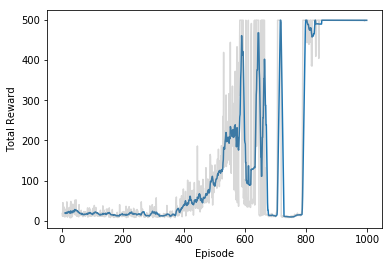

In [15]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

In [12]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.ipynb_checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render()
            # Get action
            feed = {mainQN.inputs: s.reshape((1, *s.shape))}
            Qs = sess.run(mainQN.out, feed_dict=feed)
            action = np.argmax(Qs)
            
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from .ipynb_checkpoints\cartpole.ckpt


[2017-07-25 15:13:22,223] Restoring parameters from .ipynb_checkpoints\cartpole.ckpt


In [13]:
env.close()